# Is there a correlation between Renewable Energy Consumption and Electric Vehicle Uptake?

By Aaro Lahtinen

# Datasets
    
1. Global Electric Vehicle Outlook 2022 by International Energy Agency


2. Statistical Review of World Energy 2022 by BP

Libraries

In [1]:
#pip install geopandas

In [2]:
#pip install plotly

In [1]:
#pip install pandoc

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from datetime import datetime
import geopandas as gpd
import plotly.express as px

Style

In [4]:
pd.options.mode.chained_assignment = None

In [5]:
plt.rcParams.update({'font.family':'Arial'})

In [6]:
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)

In [7]:
%matplotlib inline

In [50]:
plt.rcParams['figure.figsize'] = (15,7)

In [9]:
saved_style_state = matplotlib.rcParams.copy()

In [10]:
pd.set_option('display.max_rows', None)

Reading files...

In [11]:
ev = pd.read_csv("IEA-EV-data.csv")

In [12]:
world_geo = pd.read_csv("world_geo.csv")

In [13]:
country = pd.read_csv("countries.csv")

In [14]:
energy = pd.read_csv("energy.csv")

In [15]:
renewable_share = pd.read_csv("renewable-share-energy.csv")

# 1. EV

In [16]:
ev.head()

,region,category,parameter,mode,powertrain,year,unit,value
0,Australia,Historical,EV sales,Cars,BEV,2011,sales,49.000000
1,Australia,Historical,EV stock,Cars,BEV,2011,stock,49.000000
2,Australia,Historical,EV sales share,Cars,EV,2011,percent,0.006479
3,Australia,Historical,EV stock share,Cars,EV,2011,percent,0.000464
4,Australia,Historical,EV stock share,Cars,EV,2012,percent,0.002785


# 2. RS

In [17]:
renewable_share.head()

,Entity,Code,Year,Renewables (% equivalent primary energy)
0,Africa,NaN,1965,5.747495
1,Africa,NaN,1966,6.122062
2,Africa,NaN,1967,6.325731
3,Africa,NaN,1968,7.005293
4,Africa,NaN,1969,7.956088


# Share of Total Sales from Electric Cars (2011-2021)

In [18]:
# Sales share data for chosen country

def sales_share(country):
    v = ev[(ev.region == country) & (ev.parameter == 'EV sales share') & (ev.category == 'Historical') & (ev['mode'] == 'Cars')]

    return v

In [19]:
# Filtered DataFrame

e = ev.category == 'Historical'
evs = ev[e]
s = evs.parameter == 'EV sales share'
ev_s = evs[s]
t = ev_s['mode'] == 'Cars'
ev_share = ev_s[t]

te = ev_share.year != 2010

ev_fin = ev_share[te]

ev_fin.rename(columns = {'value': 'percentage %'}, inplace = True)

ev_fin.columns

Index(['region', 'category', 'parameter', 'mode', 'powertrain', 'year', 'unit',
       'percentage %'],
      dtype='object')

In [48]:
# Visualisation

map1 = px.choropleth(ev_fin,
locations = 'region',
locationmode = 'country names',
color = 'percentage %',
animation_frame = 'year',
scope = 'world',
height = 750,
range_color = (0,65),
title = 'Share of Total Sales from Electric Cars',
color_continuous_scale = 'plotly3',

)

In [51]:
map1

# Share of Total Sales from Electric Cars (2018-2021)

In [21]:
ev_simple = ev_fin.drop(['category', 'mode', 'parameter', 'unit', 'powertrain'], axis=1)

In [22]:
# Gets 2021 sales share data of chosen country

def sales_share_latest(country):
    s = ev[(ev.region == country) & (ev.parameter == 'EV sales share') & (ev.category == 'Historical') & (ev['mode'] == 'Cars')]

    last = s.iloc[-1].value

    return last

In [23]:
# Gets 2018 sales share data of chosen country

def sales_share_earliest(country):
    s = ev[(ev.region == country) & (ev.parameter == 'EV sales share') & (ev.category == 'Historical') & (ev['mode'] == 'Cars')]

    first = s.iloc[-4].value

    return first

In [24]:
# Creating Recorded Countries List

country_list = []

for c in ev.region:
    if c not in country_list:
        country_list.append(c)

country_list.remove('World')
country_list.remove('Europe')
country_list.remove('Rest of the world')
country_list.remove('Other Europe')
country_list.remove('Indonesia')
country_list.remove('Thailand')

country_list[15] = 'South Korea'

country_list = sorted(country_list)

country_list[-1] = country_list[-2]
country_list[-2] = 'United Kingdom'


In [25]:
# Creating lists with Sales Data

shares_latest = []
for c in country_list:
    if c == 'South Korea':
        shares_latest.append(f"{sales_share_latest('Korea')}")
    else:
        shares_latest.append(f"{sales_share_latest(c)}")

shares_earliest = []
for c in country_list:
    if c == 'South Korea':
        shares_earliest.append(f"{sales_share_earliest('Korea')}")
    else:
        shares_earliest.append(f"{sales_share_earliest(c)}")

shares_latest = list(map(float, shares_latest))
shares_earliest = list(map(float, shares_earliest))


l = len(shares_latest)
l2 = len(shares_earliest)


In [26]:
# Creating new DataFrame

df = pd.DataFrame({'2021': shares_latest})
df1 = pd.DataFrame({'2018': shares_earliest})
df2 = pd.DataFrame({'country': country_list})

all_shares = pd.concat([df2, df1, df], axis=1)
all_shares = all_shares.sort_values('2021')


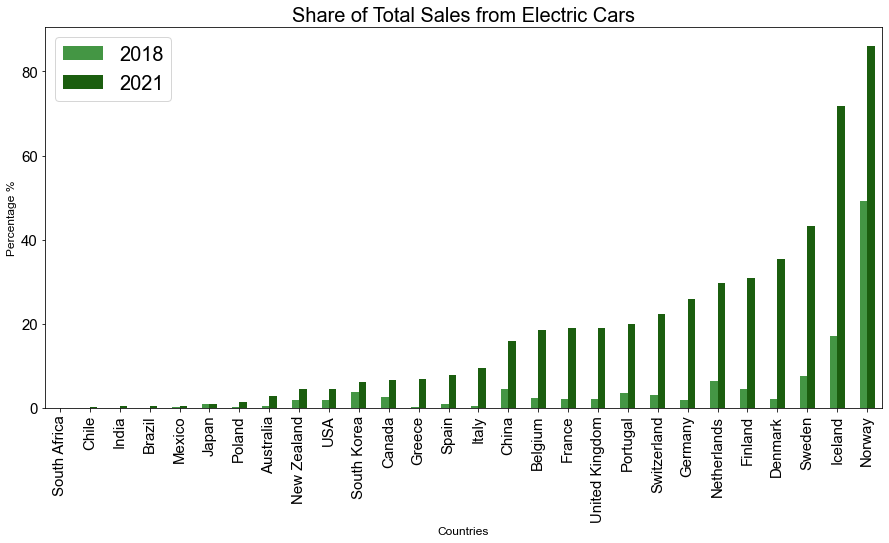

In [61]:
all_shares.plot(kind = 'bar', x = 'country', stacked = False, xlabel = 'Countries', fontsize = '12', color = {'2018': '#449644','2021': '#1b5e0f'})
plt.title('Share of Total Sales from Electric Cars', fontsize=20)
plt.xlabel('Countries', fontsize=12)
plt.ylabel('Percentage %', fontsize=12)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(prop={'size': 20})
plt.show()

# Bar Plot (Share of Primary Energy from Renewable Sources) Comparing 2000 with 2021

In [28]:
# Gets 2021 data for chosen country

is_21 = renewable_share.Year == 2021
share_21 = renewable_share[is_21]
share_21 = share_21.reset_index()
share_21 = share_21.drop('index', axis=1)

def get_2021(c):
    for i in range(len(share_21.Entity)):
        if share_21.Entity[i] == c:
            a = share_21['Renewables (% equivalent primary energy)'][i]

    #r = pd.DataFrame([a], columns=[c]) not required

    return a


In [29]:
# Gets 2000 data for chosen country

is_00 = renewable_share.Year == 2000
share_00 = renewable_share[is_00]
share_00 = share_00.reset_index()
share_00 = share_00.drop('index', axis=1)

def get_2000(c):
    for i in range(len(share_00.Entity)):
        if share_00.Entity[i] == c:
            a = share_00['Renewables (% equivalent primary energy)'][i]

    #r = pd.DataFrame([a], columns=[c]) not required

    return a

In [30]:
# Getting countries 2000

k = get_2000('Iceland')
w = get_2000('World')
e = get_2000('Europe')
af = get_2000('Africa')
a = get_2000('Asia')
ap = get_2000('Asia Pacific (BP)')
t = get_2000('Trinidad and Tobago')
au = get_2000('Australia')
o = get_2000('Oceania')

to_2000 = [af, a, ap, au, w, e, o]
countries = ['Africa', 'Asia', 'Asia Pacific (BP)', 'Australia', 'World', 'Europe', 'Oceania']

In [31]:
sorted_21 = share_21.sort_values(by=['Renewables (% equivalent primary energy)'])

In [32]:
# Getting countries 2021

ksi = get_2021('Iceland')
wor = get_2021('World')
eur = get_2021('Europe')
afr = get_2021('Africa')
asi = get_2021('Asia')
asp = get_2021('Asia Pacific (BP)')
tnt = get_2021('Trinidad and Tobago')
aus = get_2021('Australia')
oce = get_2021('Oceania')

to_2021 = [afr, asi, asp, aus, wor, eur, oce]
countries = ['Africa', 'Asia', 'Asia Pacific (BP)', 'Australia', 'World', 'Europe', 'Oceania']


In [33]:
lowest = 0
entity = []
for i in share_21.Entity:
    r = get_2021(i)
    if lowest < r < 25:
        lowest = r
        entity.append(i)

print(f"{lowest}, {entity[-1]}")


highest = 0
ent = []
for j in share_21.Entity:
     k = get_2021(j)
     if k > highest:
        highest = k
        ent.append(j)

print(f"{highest}, {ent[-1]}")

23.91737174987793, Latvia
86.8745346069336, Iceland


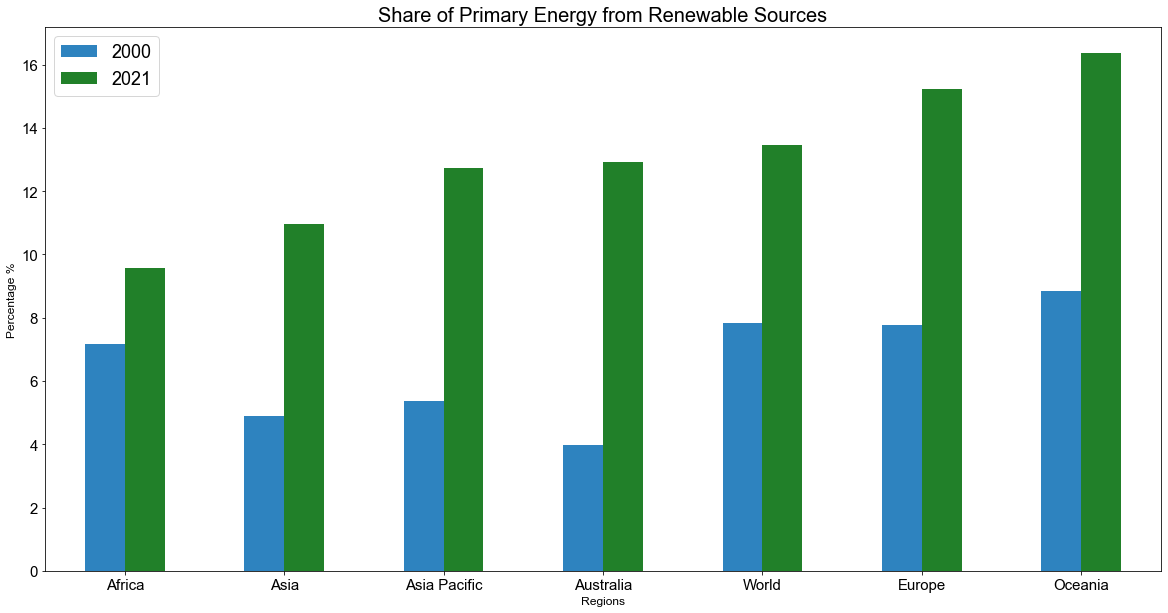

In [34]:
# Visualisation

index = ['Africa', 'Asia', 'Asia Pacific', 'Australia', 'World', 'Europe', 'Oceania']

comp_00_21 = pd.DataFrame({'2000': to_2000, '2021': to_2021}, index=index)

ax = comp_00_21.plot.bar(rot=0, color={'2000': '#2e83bf', '2021': '#218029'})

plt.title('Share of Primary Energy from Renewable Sources', fontsize=20)

plt.legend(prop={'size':18})

plt.xlabel('Regions', fontsize=12)
plt.ylabel('Percentage %', fontsize=12)

plt.show()

# Line Graph (Share of Primary Energy from Renewable Sources) 1965-2021

In [35]:
# Gets DataFrame with data for chosen country

def is_country(country):
    r = renewable_share.Entity == country
    ren = renewable_share[r]
    lst = list(ren['Renewables (% equivalent primary energy)'])
    df = pd.DataFrame(lst, columns=[country])
    return df

In [36]:
# Countries 

period = list(range(1965,2022))
aus = is_country('Australia')
nor = is_country('Norway')
usa = is_country('United States')
nzl = is_country('New Zealand')
fin = is_country('Finland')
can = is_country('Canada')
swe = is_country('Sweden')
chi = is_country('China')
ice = is_country('Iceland')
zaf = is_country('South Africa')
unk = is_country('United Kingdom')

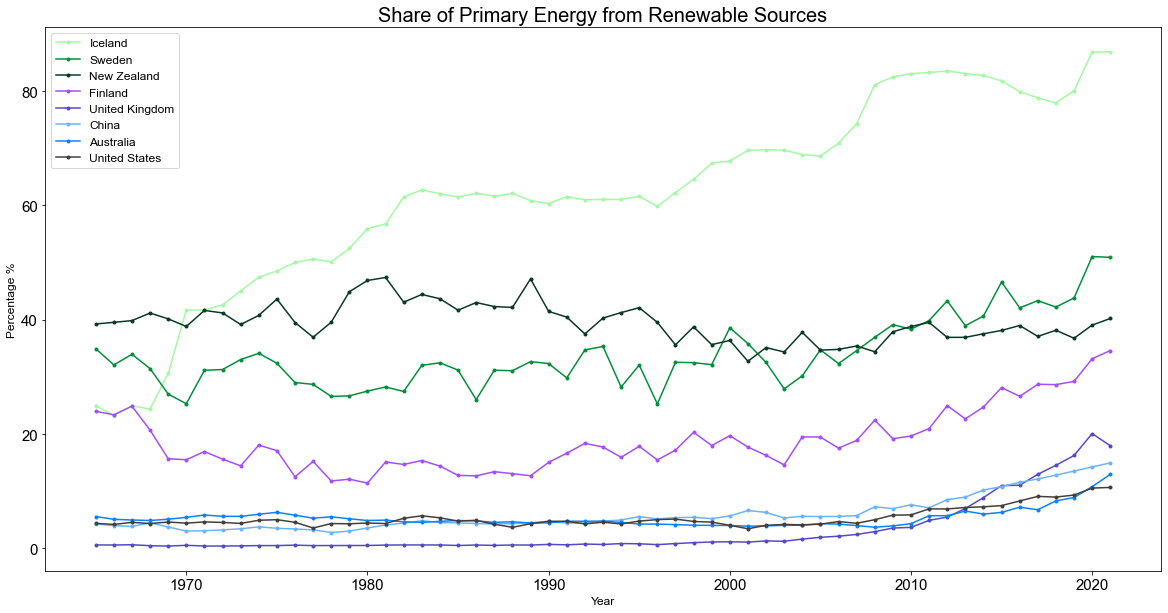

In [37]:
# Visualisation

renewable = pd.DataFrame(period, columns=['Year'])
com_ren = pd.concat([renewable, aus, nor, usa, nzl, fin, can, swe, chi, ice, zaf, unk], axis=1)

plt.title('Share of Primary Energy from Renewable Sources', fontsize=20)
plt.plot(com_ren.Year, com_ren.Iceland, '.-', color='#A2FAA3', label='Iceland')
plt.plot(com_ren.Year, com_ren.Sweden, '.-', color='#008F39', label='Sweden')
plt.plot(com_ren.Year, com_ren['New Zealand'], '.-', color='#093824', label='New Zealand')
plt.plot(com_ren.Year, com_ren.Finland, '.-', color='#a34dff', label='Finland')
plt.plot(com_ren.Year, com_ren['United Kingdom'], '.-', color='#5448C8', label='United Kingdom')
plt.plot(com_ren.Year,com_ren.China, '.-', color='#6bb3ff', label='China')
plt.plot(com_ren.Year, com_ren.Australia, '.-', color='#0a81ff', label='Australia')
plt.plot(com_ren.Year, com_ren['United States'], '.-', color='#423E3B', label='United States')

plt.xlabel('Year', fontsize=12)

plt.ylabel('Percentage %', fontsize=12)

plt.legend(loc='upper left', prop={'size':12})

plt.show()

# Choropleth (Share of Primary Energy from Renewable Sources) 1965-2021

In [38]:
# Filtered DataFrame

cull = renewable_share['Entity'].isin(world_geo.name)
a_share = renewable_share[cull]
us = renewable_share['Entity'] == 'United States'
us_ren = renewable_share[us]
eq = pd.concat([a_share, us_ren], axis=0)


In [39]:
# Visualisation

px.choropleth(eq,
locations = 'Entity',
locationmode = 'country names',
color = 'Renewables (% equivalent primary energy)',
animation_frame = 'Year',
scope = 'world',
height = 750,
range_color = (0,75),
title = 'Share of Primary Energy from Renewable Sources (1965 to 2021)',
color_continuous_scale = 'Plasma',

)

# Line Graph Share of EV Sales vs. Share of Renewables (Australia)

In [40]:
def get_sales_share(country):
    a = sales_share(country)
    a2 = a.year >= 2011
    a3 = a[a2]
    b = a3.drop(['parameter', 'region', 'category', 'mode', 'powertrain', 'unit', 'year'], axis=1)
    c = b.rename(columns = {'value': f'{country}1'})

    ab = c.reset_index()

    abc = ab.drop('index', axis=1)

    return abc

In [41]:
shares_aus = get_sales_share('Australia')
shares_nz = get_sales_share('New Zealand')
shares_us = get_sales_share('USA')
shares_uk = get_sales_share('United Kingdom')
shares_w = get_sales_share('World')
shares_eu = get_sales_share('Europe')
shares_oe = get_sales_share('Other Europe')

In [42]:

def is_country_comp(country):
    r = renewable_share.Entity == country
    ren = renewable_share[r]
    c = ren.Year >= 2011
    ren = ren[c]
    lst = list(ren['Renewables (% equivalent primary energy)'])
    df = pd.DataFrame(lst, columns=[country])
    return df

In [43]:
years = list(range(2011, 2022))
renew_aus = is_country_comp('Australia')
renew_nz = is_country_comp('New Zealand')
years = pd.DataFrame(years)

In [44]:
years.rename(columns = {0: 'year'}, inplace=True)
total = pd.concat([years, shares_aus, shares_w, shares_eu, shares_oe], axis=1)

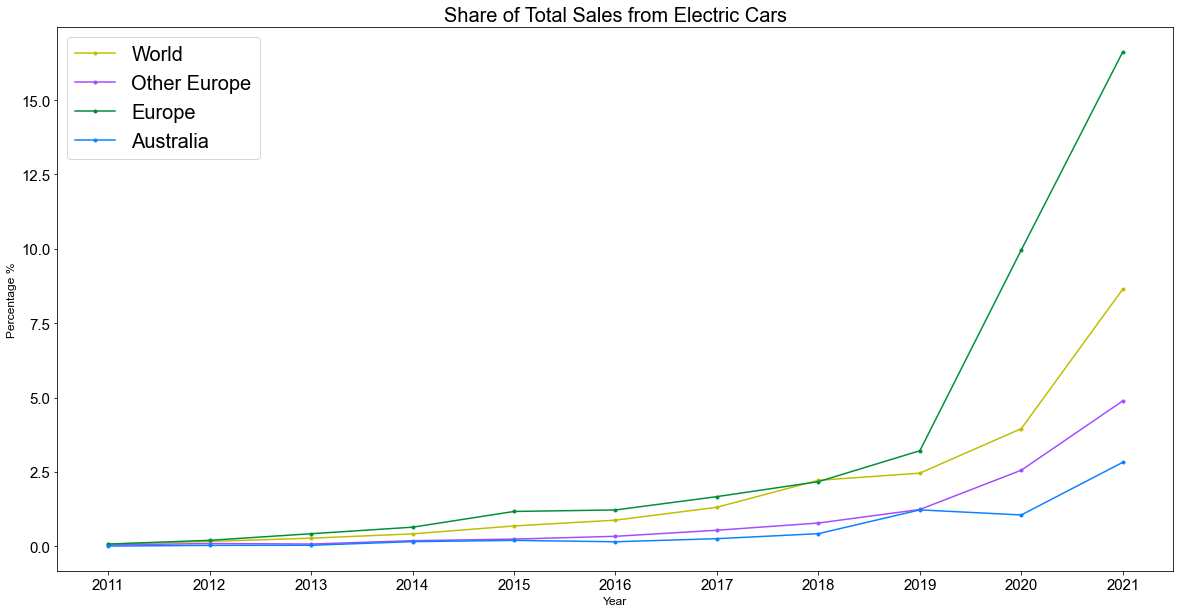

In [45]:
years = list(range(2011, 2022))

plt.title('Share of Total Sales from Electric Cars', fontsize=20)
plt.plot(total.year, total.World1, '.-', color='y', label='World')
plt.plot(total.year, total['Other Europe1'], '.-', color='#a34dff', label='Other Europe')
plt.plot(total.year, total.Europe1, '.-', color='#008F39', label='Europe')
plt.plot(total.year, total.Australia1, '.-', color='#0a81ff', label='Australia')



plt.xticks(years)
plt.xlabel('Year', fontsize=12)

plt.ylabel('Percentage %', fontsize=12)

plt.legend(loc='upper left', prop={'size':20})

plt.show()